In [321]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import Delaunay
import time
import numpy as np
import clipperpy
import matplotlib.pyplot as plt

In [322]:
# read 2d points from file
def read_points(filename):
    '''
    each line of the file is label x y z
    read the x y as numpy array
    '''
    return np.loadtxt(filename, usecols=(1,2))

In [323]:
# some vis functions
# compute delaunay triangulation
def vis_delaunay(points, tri):
    '''
    data: numpy array, (n,2) the coordinates of the vertices
    Visualize the delaunay triangulation
    '''
    # Plot the points
    plt.plot(points[:, 0], points[:, 1], 'o')

    # Plot the Delaunay triangulation
    for simplex in tri.simplices:
        simplex = np.append(simplex, simplex[0])  # Repeat the first point to close the triangle
        plt.plot(points[simplex, 0], points[simplex, 1], 'k-')

    plt.xlabel('x')
    plt.ylabel('y')
    plt.title('Delaunay Triangulation')
    plt.show()

def transform_2d_points(points, r, t):
    '''
    points: 2 by n numpy array, x, y
    r: 2 by 2 numpy array, rotation matrix
    t: 2 by 1 numpy array, translation
    return points_transformed: 2 by n numpy array, x, y
    '''
    rotated_points = r @ points
    points_transformed = rotated_points + t
    return points_transformed

def visulize_da(data1, data2, matched_points_1, matched_points_2):
    '''
    data1: n by 2 numpy array, x, y
    data2: m by 2 numpy array, x, y
    matched_points_a: 2 by k numpy array, x, y
    matched_points_b: 2 by k numpy array, x, y
    gt_r: 2 by 2 numpy array, rotation matrix
    gt_t: 2 by 1 numpy array, translation
    '''
    # draw data1 and data2
    # Create subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    
    # Plot points in set 1
    for point in data1:
        ax1.plot(point[0], point[1], 'bo')
    ax1.set_title('Set 1')

    # Plot points in set 2
    for point in data2:
        ax2.plot(point[0], point[1], 'ro')
    ax2.set_title('Set 2')

    # Draw lines connecting matched points
    for i in range(matched_points_1.shape[1]):
        point1 = matched_points_1[:, i]
        point2 = matched_points_2[:, i]
        ax1.plot(point1[0], point1[1], 'go')  # Highlight matched points in set 1
        ax2.plot(point2[0], point2[1], 'go')  # Highlight matched points in set 2

    plt.show()

def generate_DA(size_a, size_b):
    '''
    size_a: number of points in data A
    size_b: number of points in data B
    A: min(size_a, size_b) by 2 numpy array, mapping point indexed by row in data A to data B 
    '''
    DA = np.zeros((size_a*size_b, 2), dtype=np.int32)
    for i in range(size_a):
        for j in range(size_b):
            DA[i*size_b+j, 0] = i
            DA[i*size_b+j, 1] = j
    return DA


# Triangulation match

In [324]:
# perturb the data
yaw = 0/180*np.pi
dx = 0
dy = 0
rot = np.array([[np.cos(yaw), -np.sin(yaw)], [np.sin(yaw), np.cos(yaw)]])
t = np.array([[dx], [dy]])
# data2 in data1's frame
gt_yaw = 0
gt_dx = 0
gt_dy = 0
gt_rot = np.array([[np.cos(gt_yaw), -np.sin(gt_yaw)], [np.sin(gt_yaw), np.cos(gt_yaw)]])
gt_t = np.array([[gt_dx], [gt_dy]])

In [325]:
# file1 = "/home/jiuzhou/clipper_semantic_object/examples/data/robot1Map_forest.txt"
# file2 = "/home/jiuzhou/clipper_semantic_object/examples/data/robot2Map_forest.txt"
# file1 = "/home/jiuzhou/clipper_semantic_object/examples/data/robot0Map_parking.txt"
# file2 = "/home/jiuzhou/clipper_semantic_object/examples/data/robot1Map_parking.txt"
# file1 = "/home/jiuzhou/clipper_semantic_object/examples/data/robot0Map_indoor.txt"
# file2 = "/home/jiuzhou/clipper_semantic_object/examples/data/robot1Map_indoor.txt"

# file1 = "/home/jiuzhou/Downloads/1308_LT/overhead_tree_pos_2m_1308_LT.txt"
# file2 = "/home/jiuzhou/Downloads/1308_LT/sloam_cylinder_pos_1308_LT.txt"

file1 = "/home/jiuzhou/Downloads/1308_C/overhead_tree_pos_1m_1308_C.txt"
file2 = "/home/jiuzhou/Downloads/1308_C/sloam_cylinder_pos_1308_C.txt"

data1 = np.loadtxt(file1, usecols=(0,1))
data2 = np.loadtxt(file2, usecols=(0,1))
print(data1.shape)
print(data2.shape)
print(data1[0:5])
print(data2[0:5])

(405, 2)
(74, 2)
[[  75.53 -100.14]
 [  57.88  -93.51]
 [  68.89 -102.58]
 [  93.73 -118.04]
 [  71.29 -117.19]]
[[ 3.981894  3.206327]
 [-0.171213 -5.830649]
 [ 0.613402 -4.154975]
 [-3.930778 -5.883376]
 [-3.079901  9.095335]]


In [326]:
# test whether relative distance is preserved
# original_data2 = data2
# rand_idx = np.random.choice(data2.shape[0], 10, replace=False)
# rand_idx1 = np.random.choice(data2.shape[0], 10, replace=False)
# start_points = original_data2[rand_idx, :]
# end_points = original_data2[rand_idx1, :]
# print(start_points)
# print(end_points)
# relative_distance0 = np.linalg.norm(start_points - end_points, axis=1)
# print(relative_distance0)

In [327]:
# perturb data
data2 = transform_2d_points(data2.T, rot, t).T
gt_rot = rot
gt_t = t

In [328]:
tri1 = Delaunay(data1)
tri2 = Delaunay(data2)

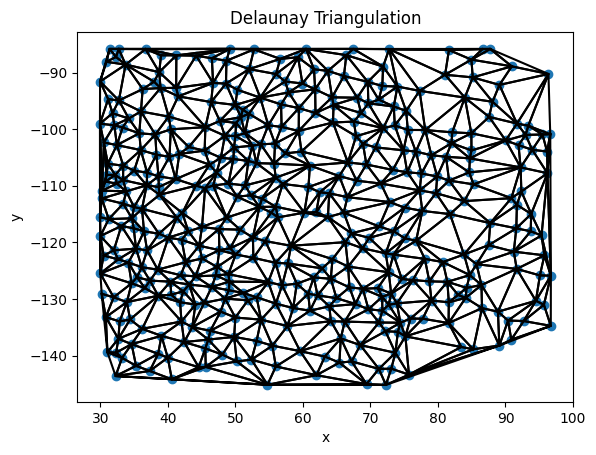

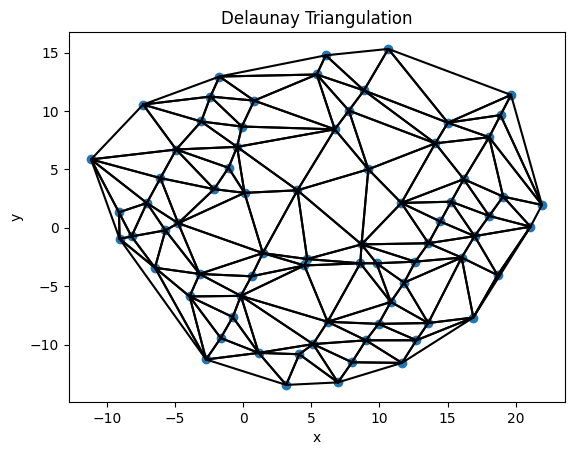

In [329]:
vis_delaunay(data1, tri1)
vis_delaunay(data2, tri2)

In [330]:
def computeTriDiff(tri1, tri2, data1, data2):
    triangle_diff = np.zeros((tri1.simplices.shape[0], tri2.simplices.shape[0]))
    triangle_points_set1 = np.zeros((tri1.simplices.shape[0], 6))
    triangle_points_set2 = np.zeros((tri2.simplices.shape[0], 6))
    print(tri1.simplices.shape[0])
    print(tri2.simplices.shape[0])
    for i in range(tri1.simplices.shape[0]):
        for j in range(tri2.simplices.shape[0]):
            triangle1_points = data1[tri1.simplices[i], :]
            triangle2_points = data2[tri2.simplices[j], :]
            # compute the centroid of the triangle
            centroid1 = np.mean(triangle1_points, axis=0)
            centroid2 = np.mean(triangle2_points, axis=0)
            # compute the distance between corners and centroid and sort them from large to small
            dist1 = np.linalg.norm(triangle1_points-centroid1, axis=1)
            dist2 = np.linalg.norm(triangle2_points-centroid2, axis=1)
            # sort the points based on the distance
            triangle1_points = triangle1_points[np.argsort(dist1), :]
            triangle2_points = triangle2_points[np.argsort(dist2), :]
            triangle_points_set1[i] = triangle1_points.flatten()
            triangle_points_set2[j] = triangle2_points.flatten()
            # compute the difference
            dist1 = np.sort(dist1)
            dist2 = np.sort(dist2)
            triangle_diff[i,j] = np.linalg.norm(dist1-dist2)
    return triangle_diff, triangle_points_set1, triangle_points_set2

def matchTri(triangle_diff, thres = 0.2):
    # find the matching triangles
    mask =  np.where(triangle_diff < thres, triangle_diff, 0)
    mask_idx = np.argwhere(mask)
    return mask_idx

In [331]:
triangle_diff, triangle_points_set1, triangle_points_set2 = computeTriDiff(tri1, tri2, data1, data2)
matched_idx = matchTri(triangle_diff)
print("number of matched triangles:",matched_idx.shape)

790
132
number of matched triangles: (1422, 2)


In [332]:
matched_points1 = triangle_points_set1[matched_idx[:,0], :]
matched_points2 = triangle_points_set2[matched_idx[:,1], :]
matched_points1_reshaped = matched_points1.reshape((matched_points1.shape[0]*3, 2))
matched_points2_reshaped = matched_points2.reshape((matched_points2.shape[0]*3, 2))

# Clipper

In [333]:
# prepare the data for clipper
point1 = matched_points1_reshaped.astype(np.float64).T
point2 = matched_points2_reshaped.astype(np.float64).T
# compute A
A = np.arange(point1.shape[1])
A = np.hstack((A.reshape(-1, 1), A.reshape(-1, 1)))
A = A.astype(np.int32)
print("A shape: ", A.shape)
print("point1 shape: ", point1.shape)
print("point2 shape: ", point2.shape)

A shape:  (4266, 2)
point1 shape:  (2, 4266)
point2 shape:  (2, 4266)


In [334]:
# all to all data association
# point1 = data1.T
# point2 = data2.T
# A = generate_DA(point1.shape[1], point2.shape[1])

In [339]:
# clipper solver
iparams = clipperpy.invariants.EuclideanDistanceParams()
iparams.sigma = 1
iparams.epsilon = 1
invariant = clipperpy.invariants.EuclideanDistance(iparams)

params = clipperpy.Params()
params.rounding = clipperpy.Rounding.DSD_HEU
clipper = clipperpy.CLIPPER(invariant, params)

clipper.score_pairwise_consistency(point1, point2, A)
clipper.solve()
Ain = clipper.get_selected_associations()
print("Ain shape: ", Ain.shape)

Ain shape:  (23, 2)


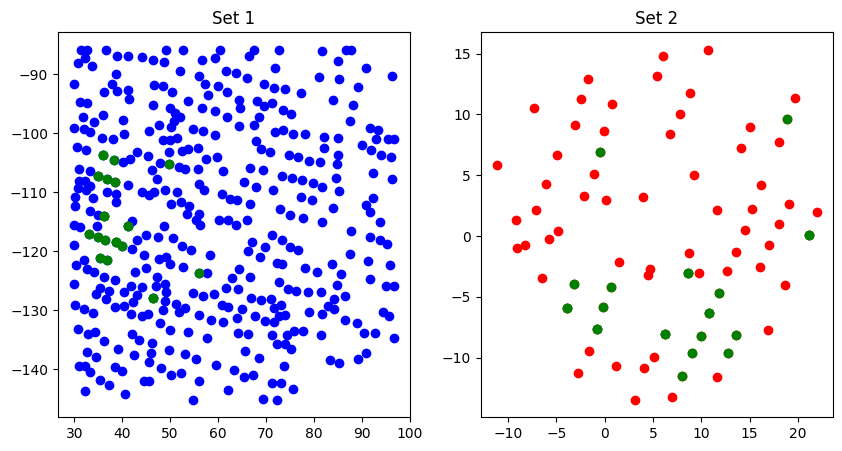

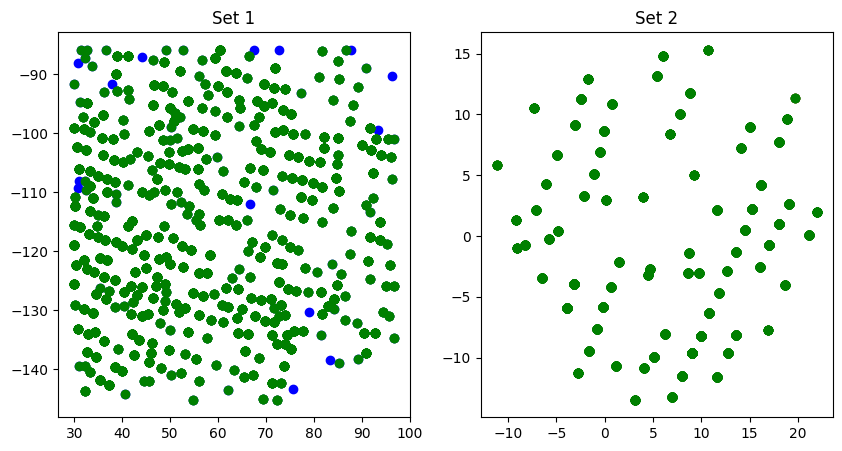

In [340]:
# visualize the matching
matched_points_1 = point1[:, Ain[:, 0]]
matched_points_2 = point2[:, Ain[:, 1]]
visulize_da(data1,data2,matched_points_1, matched_points_2)
visulize_da(data1,data2, matched_points1_reshaped.T, matched_points2_reshaped.T)

# transformation estimation

In [341]:
def tf_estimation_lsq(matched_points_a, matched_points_b):
    '''
    matched_points_a: 2 by n numpy array, x, y
    matched_points_b: 2 by n numpy array, x, y
    '''
    tf = np.eye(3)
    centroid_a = np.mean(matched_points_a, axis=1)
    centroid_b = np.mean(matched_points_b, axis=1)
    H = np.zeros((2, 2))
    for i in range(matched_points_a.shape[1]):
        H += np.outer(matched_points_a[:, i] - centroid_a, matched_points_b[:, i] - centroid_b)
    U, S, Vt = np.linalg.svd(H)
    R = Vt.T @ U.T
    if np.linalg.det(R) < 0:
        Vt[1, :] *= -1
        R = Vt.T @ U.T
    t = -R @ centroid_a + centroid_b
    tf[0:2, 0:2] = R
    tf[0:2, 2] = t
    return tf

def visualize_matched_points(matched_points_a, matched_points_b, tf, displacement= 80):
    transformed_points_b = np.linalg.inv(tf) @ np.vstack((matched_points_b, np.ones((1, matched_points_b.shape[1]))))
    plt.plot(matched_points_a[0, :], matched_points_a[1, :], 'go')
    plt.plot(transformed_points_b[0, :]+displacement, transformed_points_b[1, :], 'ro')
    plt.show()

estimated transformation: 
[[   0.17760004   -0.98410275 -112.6794705 ]
 [   0.98410275    0.17760004  -23.10220191]
 [   0.            0.            1.        ]]
ground truth transformation: 
[[ 1. -0.  0.]
 [ 0.  1.  0.]
 [ 0.  0.  1.]]


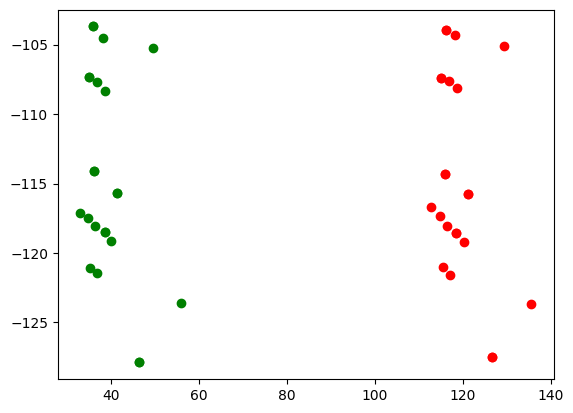

In [342]:
tf_estimated = tf_estimation_lsq(matched_points_1, matched_points_2)
print("estimated transformation: ")
print(tf_estimated)
print("ground truth transformation: ")
print(np.vstack((np.hstack((gt_rot, gt_t)), [0, 0, 1])))
visualize_matched_points(matched_points_1, matched_points_2, tf_estimated)